# **Homework #4_P2**

## **Problem 2: Data Hallucination for Few-shot Learning (50%)**
### **Task Definition**
In this problem, you will have to improve the prototypical network by data hallucination. Your hallucinator will take a seed example x and a noise vector z as input, and produce a hallucinated example as output.

Hint   
1. For the model architecture, the CNN Feature Extractor is provided
in P.26. You only need to design the architecture of the MLP and Hallucinator.  
2. For the objective function, you can only use the cross entropy loss.  
3. When calculating the prototypes of each class, please average all the real data and hallucinated data. (Do not use weighted mean)

# Model Performance (15%)
• Mean accuracy under **5-way 1-shot** setting (Problem 2-1) should be above the baseline score to get points   
*   On the validation set (10%): **0.46** [should be reported in Problem 2-1]
*   On the test set (5%): **0.44**   
 
• You have to use the test case provided by the TAs to calculate your mean accuracy on the validation set.    
• TAs will execute your code to check if you pass the baseline.    
• Only TAs have the test data.

In [ ]:
# connect to drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
path = 'drive/My Drive/senior_1/DLCV/HW/hw4'

Mounted at /content/drive


In [ ]:
!gdown --id '1Ez4TCdglld8vNjtIFSUyqy8l09cPkrdW' --output hw4_data.zip # 下載資料集
!unzip hw4_data.zip # 解壓縮

'''
    The dataset consists of 48,000 84x84 RGB images in 80 classes.
    1. train                  # training images directory (64 class, each class has 600 images)
    2. val                    # validation images directory (16 class, each class has 600 images)
    3. train.csv              # training image csv file
    4. val.csv                # validation image csv file
    5. val_testcase.csv       # validation test case file
    6. val_testcase_gt.csv    # ground truth for validation test case
'''

In [ ]:
# set packages
!pip3 install certifi==2020.6.20
!pip3 install cycler==0.10.0
!pip3 install joblib==0.17.0
!pip3 install kiwisolver==1.2.0
!pip3 install matplotlib==3.3.2
!pip3 install numpy==1.18.1
!pip3 install pandas==1.1.3
!pip3 install Pillow==8.0.0
!pip3 install pyparsing==2.4.7
!pip3 install python-dateutil==2.8.1
!pip3 install pytz==2020.1
!pip3 install scikit-learn==0.21.3
!pip3 install scipy==1.2.1
!pip3 install six==1.15.0
!pip3 install torch==1.4.0
!pip3 install torchvision==0.5.0

In [ ]:
# Import 需要的套件
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import Sampler
import time
import pandas as pd
import random
import scipy.misc
import argparse
import imageio
from torch.autograd import Variable
from torch.optim import Adam, AdamW
import csv
from sklearn.manifold import TSNE
from PIL import Image
import matplotlib.pyplot as plt

# 固定隨機種子
def same_seeds(seed=123):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("torchvision.__version__ =", torchvision.__version__)
    print("torch.cuda.is_available() =", torch.cuda.is_available())

same_seeds(123)

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True


# Dataset
在 PyTorch 中，我們可以利用 torch.utils.data 的 Dataset 及 DataLoader 來"包裝" data，使後續的 training 及 testing 更為方便。

Dataset 需要 overload 兩個函數：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必須要回傳 dataset 的大小，而 \_\_getitem\_\_ 則定義了當程式利用 [ ] 取值時，dataset 應該要怎麼回傳資料。

實際上我們並不會直接使用到這兩個函數，但是使用 DataLoader 在 enumerate Dataset 時會使用到，沒有實做的話會在程式運行階段出現 error。


In [ ]:
# mini-Imagenet dataset
filenameToPILImage = lambda x: Image.open(x)  

class MiniDataset(Dataset):
    def __init__(self, csv_path, data_dir, mode):
        self.data_dir = data_dir
        self.data_df = pd.read_csv(csv_path).set_index("id") # 把 index 設成 id
        self.mode = mode

        # training 時需做 data augmentation
        self.train_transform = transforms.Compose([
            filenameToPILImage, # 轉成 python 圖片
            transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
            transforms.RandomRotation(15), # 隨機旋轉圖片，表示在（-15，+15）之間隨機旋轉，旋轉後空的地方補 0
            transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization) ps. Tensor 為多維張量
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize
        ])

        # testing 時不需做 data augmentation
        self.test_transform = transforms.Compose([
            filenameToPILImage,                                    
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize
        ])

    def __getitem__(self, index):
        path = self.data_df.loc[index, "filename"]
        label = self.data_df.loc[index, "label"]
        if self.mode == 'train':
            image = self.train_transform(os.path.join(self.data_dir, path))
        else:
            image = self.test_transform(os.path.join(self.data_dir, path))
        return image, label

    def __len__(self):
        return len(self.data_df)

class GeneratorSampler(Sampler):
    def __init__(self, episode_file_path, mode):
        if mode == 'train':
            episode_df = episode_file_path.set_index("episode_id")
        else:
            episode_df = pd.read_csv(episode_file_path).set_index("episode_id")
        self.sampled_sequence = episode_df.values.flatten().tolist()

    def __iter__(self):
        return iter(self.sampled_sequence) 

    def __len__(self):
        return len(self.sampled_sequence)

# create N-way-K-shot traincase_csv
def create_traincase(N, K, N_query, num_episode, train_csv):
    column_name = ['episode_id']
    for n in range(N):
        for k in range(K):
            column_name.append('class{}_support{}'.format(str(n), str(k)))
    for q in range(N*N_query):
        column_name.append('query{}'.format(str(q)))
    traincase_csv = pd.DataFrame(np.zeros([num_episode, len(column_name)]), columns=column_name).astype(int)
    traincase_csv['episode_id'] = range(0, num_episode)
    
    train_data_index = pd.read_csv(train_csv)
    for episode in range(num_episode):
        sampling_class_list = [] # get N class
        sampling_support_list = []
        sampling_query_list = []

        for i in np.random.choice(range(0, len(train_data_index['label'].unique())), N, replace=False):
            sampling_class_list.append(train_data_index['label'].unique()[i]) # get N different class

        for sampling_class in sampling_class_list:
            data = train_data_index[train_data_index['label'] == sampling_class]['id'].reset_index()
            data_index =  np.random.choice(len(data), K + N_query, replace=False)
            for i in range(len(data_index)):
                if i < K:
                    sampling_support_list.append(data['id'][data_index[i]])
                else: 
                    sampling_query_list.append(data['id'][data_index[i]])

        for n in range(N):
            for k in range(K):
                traincase_csv.loc[episode, 'class{}_support{}'.format(str(n), str(k))] = sampling_support_list[n*K + k]
        for q in range(N*N_query):
            traincase_csv.loc[episode, 'query{}'.format(str(q))] = sampling_query_list[q]

    return traincase_csv

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

# Model

In [ ]:
class Convnet(nn.Module):

    def __init__(self, in_channels = 3, hid_channels = 64, out_channels = 64):
        super(Convnet, self).__init__()

        self.encoder = nn.Sequential(
            # input_size = (84, 84, 3)
            # output_size = (input_size-kernel_size+2*padding)/stride + 1
            nn.Conv2d(in_channels, hid_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(hid_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, hid_channels, 42, 42]

            nn.Conv2d(hid_channels, hid_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(hid_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, hid_channels, 21, 21]

            nn.Conv2d(hid_channels, hid_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(hid_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, hid_channels, 10, 10]

            nn.Conv2d(hid_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            # [batch_size, out_channels, 5, 5]

        )     

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1) # [batch_size, out_channels*5*5]

class Hallucinator(nn.Module):

    def __init__(self, in_channels = 1600, hid_channels = 800, out_channels = 1600):
        super(Hallucinator, self).__init__()

        self.linear = nn.Sequential(
            # flatten
            nn.Linear(in_channels, hid_channels, bias=True),
            nn.BatchNorm1d(hid_channels),
            nn.ReLU(inplace=True),
            # [batch_size, hid_channels]

            nn.Linear(hid_channels, hid_channels, bias=True),
            nn.BatchNorm1d(hid_channels),
            nn.ReLU(inplace=True),
            # [batch_size, hid_channels]

            nn.Linear(hid_channels, out_channels, bias=True),
            # [batch_size, out_channels]
        ) 

    def forward(self, x):
        x = self.linear(x)
        return x

def euclidean_dist(x, y):
    # x: N x D ex. (75, 1600)
    # y: M x D ex. (5, 1600)
    n = x.size(0) # ex. 75
    m = y.size(0) # ex. 5
    d = x.size(1) # ex. dim = 1600
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2) # ex. 75 個 data 對每一個 class (5 個) 的距離 (75, 5)

# Training

In [ ]:
# create N-way-K-shot train_loader
def create_train_loader(traincase_csv):
    train_loader = DataLoader(
            train_dataset, batch_size=train_N_way * (train_N_query + train_N_shot), num_workers=3, pin_memory=False, 
            worker_init_fn=worker_init_fn, sampler=GeneratorSampler(traincase_csv, 'train'))
    return train_loader

# set state
same_seeds(123) 

# sethyper parameters
train_N_way = 20
train_N_shot = 1 # first 5 shot => 1 shot
train_N_query = 15
val_N_way = 5
val_N_shot = 1    
val_N_query = 15
num_episode = 400
M = 5  

# set data path
workspace_dir = "./hw4_data"
train_csv = os.path.join(workspace_dir, "train.csv")
train_data_dir = os.path.join(workspace_dir, "train")
val_csv = os.path.join(workspace_dir, "val.csv")
val_data_dir = os.path.join(workspace_dir, "val")
valcase_csv = os.path.join(workspace_dir, "val_testcase.csv")
gt_csv = os.path.join(workspace_dir, "val_testcase_gt.csv")
output_csv = os.path.join(path, "p2_output.csv")

# set dataset
train_dataset = MiniDataset(train_csv, train_data_dir, 'train')
val_dataset = MiniDataset(val_csv, val_data_dir, 'test')
print('finish dataset')

val_loader = DataLoader(
        val_dataset, batch_size=val_N_way * (val_N_query + val_N_shot), num_workers=3, pin_memory=False, 
        worker_init_fn=worker_init_fn, sampler=GeneratorSampler(valcase_csv, 'val'))
print('finish data_loader')

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True
finish dataset
finish data_loader


In [ ]:
# set model
if torch.cuda.is_available():
    convnet = Convnet().cuda()
    hallucinator = Hallucinator().cuda()
    convnet.load_state_dict(torch.load(os.path.join(path, "p2_convnet_20way_5shot_x.pkl")))
    hallucinator.load_state_dict(torch.load(os.path.join(path, "p2_hallucinator_20way_5shot_x.pkl")))
else:
    convnet = Convnet()
    hallucinator = Hallucinator()
    convnet.load_state_dict(torch.load(os.path.join(path, "p2_convnet_20way_5shot.pkl"), map_location='cpu'))
    hallucinator.load_state_dict(torch.load(os.path.join(path, "p2_hallucinator_20way_5shot.pkl"), map_location='cpu'))

loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
convnet_optimizer = torch.optim.Adam(convnet.parameters(), lr=0.001) # optimizer 使用 Adam 
hallucinator_optimizer = torch.optim.Adam(hallucinator.parameters(), lr=0.001) # optimizer 使用 Adam
softmax = nn.Softmax(dim=1)

# set hyperparameters
num_epoch = 250
best_val_acc = 0.0

for epoch in range(num_epoch):
    training_epoch_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    traincase_csv = create_traincase(N=train_N_way, K=train_N_shot, N_query=train_N_query, num_episode=num_episode, train_csv=train_csv)
    train_loader = create_train_loader(traincase_csv)
    print("finish train_loader")

    convnet.train() 
    hallucinator.train()

    # each batch represent one episode (support data + query data)
    for i, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data = data.cuda()
        # split data into support and query data
        support_input = data[:train_N_way*train_N_shot, :, :, :] 
        query_input   = data[train_N_way*train_N_shot: , :, :, :]
        # create the relative label (0 ~ N_way-1) for query data
        label_encoder = {target[i*train_N_shot] : i for i in range(train_N_way)}
        if torch.cuda.is_available():
            query_label = torch.cuda.LongTensor([label_encoder[class_name] for class_name in target[train_N_way*train_N_shot:]])
        else:
            query_label = torch.LongTensor([label_encoder[class_name] for class_name in target[train_N_way*train_N_shot:]])

        convnet_optimizer.zero_grad() # 用 optimizer 將 convnet 參數的 gradient 歸零
        hallucinator_optimizer.zero_grad()

        support_encode = convnet(support_input).view(train_N_way, train_N_shot, -1) # extract the feature of support
        query_encode = convnet(query_input) # extract the feature of query
        noise = torch.randn(train_N_way, M, support_encode.shape[-1]).cuda() 
        for j in range(train_N_way): # generate hallucination data
            support_seed = support_encode[j][random.randint(0, train_N_shot-1)] # sample one feature in each class
            for m in range(M):
                noise[j][m] += support_seed # add seed to noise

        noise = hallucinator(noise.view(train_N_way*M, -1))
        support_proto = torch.cat((support_encode, noise.view(train_N_way, M, -1)), dim=1).mean(1)
        dists = euclidean_dist(query_encode, support_proto) 
        p = softmax(-dists)

        batch_loss = loss(p, query_label) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        convnet_optimizer.step() # 以 optimizer 用 gradient 更新參數值
        hallucinator_optimizer.step()

        train_acc += np.mean(np.argmax(p.cpu().data.numpy(), axis=1) == query_label.cpu().data.numpy())
        train_loss += batch_loss.item()
    
    convnet.eval() 
    hallucinator.eval()

    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            if torch.cuda.is_available():
                data = data.cuda()
            # split data into support and query data
            support_input = data[:val_N_way*val_N_shot, :, :, :] 
            query_input   = data[val_N_way*val_N_shot: , :, :, :]
            # create the relative label (0 ~ N_way-1) for query data
            label_encoder = {target[i*val_N_shot] : i for i in range(val_N_way)}
            if torch.cuda.is_available():
                query_label = torch.cuda.LongTensor([label_encoder[class_name] for class_name in target[val_N_way*val_N_shot:]])
            else:
                query_label = torch.LongTensor([label_encoder[class_name] for class_name in target[val_N_way*val_N_shot:]])

            support_encode = convnet(support_input).view(val_N_way, val_N_shot, -1) # extract the feature of support
            query_encode = convnet(query_input) # extract the feature of query
            noise = torch.randn(val_N_way, M, support_encode.shape[-1]).cuda()
            for j in range(val_N_way): # generate hallucination data
                support_seed = support_encode[j][random.randint(0, val_N_shot-1)]
                for m in range(M):
                    noise[j][m] += support_seed

            noise = hallucinator(noise.view(val_N_way*M, -1))
            support_proto = torch.cat((support_encode, noise.view(val_N_way, M, -1)), dim=1).mean(1)
            dists = euclidean_dist(query_encode, support_proto)
            p = softmax(-dists)

            batch_loss = loss(p, query_label) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
            val_acc += np.mean(np.argmax(p.cpu().data.numpy(), axis=1) == query_label.cpu().data.numpy())
            val_loss += batch_loss.item()

        if val_acc > best_val_acc :
            best_val_acc = val_acc
            torch.save(convnet.state_dict(), os.path.join(path, "p2_model", "p2_convnet_{}way_{}shot.pkl".format(str(train_N_way), str(train_N_shot))))
            torch.save(hallucinator.state_dict(), os.path.join(path, "p2_model", "p2_hallucinator_{}way_{}shot.pkl".format(str(train_N_way), str(train_N_shot))))
            print('save model')

    print('epoch : {}, training epoch time: {:.4f} (sec)'.format(epoch, time.time()-training_epoch_time))
    print('train acc: {:.4f}, train loss: {:.5f}, val acc: {:.4f}, val loss: {:.5f}, best val acc: {:.4f}'.format(
        train_acc/len(train_loader), train_loss/len(train_loader), val_acc/len(val_loader), val_loss/len(val_loader), best_val_acc/len(val_loader)
    ))

finish train_loader
save model
epoch : 0, training epoch time: 187.8018 (sec)
train acc: 0.2880, train loss: 2.78885, val acc: 0.4386, val loss: 1.46292, best val acc: 0.4386
finish train_loader
save model
epoch : 1, training epoch time: 177.3564 (sec)
train acc: 0.2886, train loss: 2.78774, val acc: 0.4436, val loss: 1.45794, best val acc: 0.4436
finish train_loader
save model
epoch : 2, training epoch time: 174.1104 (sec)
train acc: 0.2866, train loss: 2.79040, val acc: 0.4510, val loss: 1.45033, best val acc: 0.4510
finish train_loader
epoch : 3, training epoch time: 172.9828 (sec)
train acc: 0.2867, train loss: 2.79009, val acc: 0.4477, val loss: 1.45421, best val acc: 0.4510
finish train_loader
epoch : 4, training epoch time: 171.2823 (sec)
train acc: 0.2889, train loss: 2.78813, val acc: 0.4432, val loss: 1.45872, best val acc: 0.4510
finish train_loader
save model
epoch : 5, training epoch time: 169.6977 (sec)
train acc: 0.2893, train loss: 2.78763, val acc: 0.4581, val loss: 1.

KeyboardInterrupt: ignored

# Testing

In [ ]:
# set state
same_seeds(123) 

# set hyperparameters
val_N_way = 5
val_N_shot = 1    
val_N_query = 15
M = 5

# set data path
workspace_dir = "./hw4_data"
val_csv = os.path.join(workspace_dir, "val.csv")
val_data_dir = os.path.join(workspace_dir, "val")
valcase_csv = os.path.join(workspace_dir, "val_testcase.csv")
gt_csv = os.path.join(workspace_dir, "val_testcase_gt.csv")
output_csv = os.path.join(path, "p2_output_{}way_{}shot.csv".format(20, 1))

# set dataset
val_dataset = MiniDataset(val_csv, val_data_dir, 'test')
print('finish dataset')

val_loader = DataLoader(
        val_dataset, batch_size=val_N_way * (val_N_query + val_N_shot), num_workers=3, pin_memory=False, 
        worker_init_fn=worker_init_fn, sampler=GeneratorSampler(valcase_csv, 'val'))
print('finish data_loader')

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True
finish dataset
finish data_loader


In [ ]:
# set state
same_seeds(123)

# set model
if torch.cuda.is_available():
    convnet = Convnet().cuda()
    hallucinator = Hallucinator().cuda()
    convnet.load_state_dict(torch.load(os.path.join(path, "p2_model", "p2_convnet_20way_1shot.pkl")))
    hallucinator.load_state_dict(torch.load(os.path.join(path, "p2_model", "p2_hallucinator_20way_1shot.pkl")))
else:
    convnet = Convnet()
    hallucinator = Hallucinator()
    convnet.load_state_dict(torch.load(os.path.join(path, "p2_model", "p2_convnet_20way_1shot.pkl"), map_location='cpu'))
    hallucinator.load_state_dict(torch.load(os.path.join(path, "p2_model", "p2_hallucinator_20way_1shot.pkl"), map_location='cpu'))

drop_list = ['class0_support0', 'class1_support0', 'class2_support0', 'class3_support0', 'class4_support0']
output_file = pd.read_csv(valcase_csv).copy().drop(columns=drop_list)
convnet.eval()
hallucinator.eval()

with torch.no_grad():
    val_acc = 0.0
    val_loss = 0.0
    softmax = nn.Softmax(dim=1)
    loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
    
    for i, (data, target) in enumerate(val_loader):
        if torch.cuda.is_available():
            data = data.cuda()
        # split data into support and query data
        support_input = data[:val_N_way*val_N_shot, :, :, :] 
        query_input   = data[val_N_way*val_N_shot: , :, :, :]
        # create the relative label (0 ~ N_way-1) for query data
        label_encoder = {target[i*val_N_shot] : i for i in range(val_N_way)}
        if torch.cuda.is_available():
            query_label = torch.cuda.LongTensor([label_encoder[class_name] for class_name in target[val_N_way*val_N_shot:]])
        else:
            query_label = torch.LongTensor([label_encoder[class_name] for class_name in target[val_N_way*val_N_shot:]])

        support_encode = convnet(support_input).view(val_N_way, val_N_shot, -1) # extract the feature of support
        query_encode = convnet(query_input) # extract the feature of query
        noise = torch.randn(val_N_way, M, support_encode.shape[-1]).cuda()
        # torch.save(noise, os.path.join(path, "noise.pkl"))
        # noise = torch.load(os.path.join(path, "noise.pkl"))
        for j in range(val_N_way): # generate hallucination data
            support_seed = support_encode[j][random.randint(0, val_N_shot-1)]
            for m in range(M):
                noise[j][m] += support_seed

        noise = hallucinator(noise.view(val_N_way*M, -1))
        support_proto = torch.cat((support_encode, noise.view(val_N_way, M, -1)), dim=1).mean(1)
        dists = euclidean_dist(query_encode, support_proto)
        p = softmax(-dists)

        batch_loss = loss(p, query_label) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        val_acc += np.mean(np.argmax(p.cpu().data.numpy(), axis=1) == query_label.cpu().data.numpy())
        val_loss += batch_loss.item()

        for q in range(val_N_way*val_N_query):
            output_file.loc[i, 'query{}'.format(str(q))] = np.argmax(p.cpu().data.numpy(), axis=1)[q]

print('val acc: {:.4f}, val loss: {:.5f}'.format(val_acc/len(val_loader), val_loss/len(val_loader)))
output_file = output_file.set_index("episode_id")
output_file.to_csv(output_csv)

# from google.colab import files
        
# # 存到本機端
# files.download(output_csv)

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True
val acc: 0.4759, val loss: 1.42694


In [ ]:
# read your prediction file
with open(output_csv, mode='r') as pred:
    reader = csv.reader(pred)
    next(reader, None)  # skip the headers
    pred_dict = {int(rows[0]): np.array(rows[1:]).astype(int) for rows in reader}

# read ground truth data
with open(gt_csv, mode='r') as gt:
    reader = csv.reader(gt)
    next(reader, None)  # skip the headers
    gt_dict = {int(rows[0]): np.array(rows[1:]).astype(int) for rows in reader}

if len(pred_dict) != len(gt_dict):
    sys.exit("Test case length mismatch.")

episodic_acc = []
for key, value in pred_dict.items():
    if key not in gt_dict:
        sys.exit("Episodic id mismatch: \"{}\" does not exist in the provided ground truth file.".format(key))

    episodic_acc.append((gt_dict[key] == value).mean().item())

episodic_acc = np.array(episodic_acc)
mean = episodic_acc.mean()
std = episodic_acc.std()

print('Accuracy: {:.2f} +- {:.2f} %'.format(mean * 100, 1.96 * std / (600)**(1/2) * 100))

Accuracy: 47.59 +- 0.86 %


# Report (35%)

In Problem 2-1 and 2-2, you will have to improve the prototypical network by data hallucination to perform 5-way 1-shot classification and analyze the quality of your hallucinated data by t-SNE.

1. (10%) Describe the architecture & implementation details of your model. (Include but not limited to the number of training episodes, distance function, learning rate schedule, data augmentation, optimizer, and N-way K-shot M-augmentation setting for meta-train and meta-test phase)   
  **Please report the accuracy on validation set under 5-way 1-shot setting (during inference).    
• You should select 1 <= M <= 200.    
• The accuracy should be the same as your model performance in P.13.    
• TAs will run your code to verify the performance.**

Hint   
M-augmentation: each class hallucinate M more data.

In [ ]:
print(Convnet())
print(Hallucinator())

Convnet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14

2. (10%) To analyze the quality of your hallucinated data, please visualize the real and hallucinated (training) data in the latent space (the space where you calculate the prototypes of each class, e.g., the output of the MLP layer) by mapping the features to 2D space (with t-SNE). Briefly explain your result of t-SNE visualization. Example for fig2-3.png is shown below.   
• In the t-SNE visualization, you should have 5 classes with different colors, and each class has at least
200 real data and 20 hallucinated data. Real data are shown as crosses and hallucinated data are
shown as triangles.

In [ ]:
# create N-way-K-shot train_loader
def create_train_loader(traincase_csv):
    train_loader = DataLoader(
            train_dataset, batch_size=N_way * (N_query + N_shot), num_workers=3, pin_memory=False, 
            worker_init_fn=worker_init_fn, sampler=GeneratorSampler(traincase_csv, 'train'))
    return train_loader

# set state
same_seeds(123)

# set data path
workspace_dir = "./hw4_data"
train_csv = os.path.join(workspace_dir, "train.csv")
train_data_dir = os.path.join(workspace_dir, "train")

# set dataset
train_dataset = MiniDataset(train_csv, train_data_dir, 'train')

# set hyperparameters
N_way = 5 # 5 classes
N_shot = 200 # 200 real data   
M = 20 # 20 hallucinated data
N_query = 15

# set model
if torch.cuda.is_available():
    convnet = Convnet().cuda()
    hallucinator = Hallucinator().cuda()
    convnet.load_state_dict(torch.load(os.path.join(path, "p2_model", "p2_convnet_20way_1shot.pkl")))
    hallucinator.load_state_dict(torch.load(os.path.join(path, "p2_model", "p2_hallucinator_20way_1shot.pkl")))
else:
    convnet = Convnet()
    hallucinator = Hallucinator()
    convnet.load_state_dict(torch.load(os.path.join(path, "p2_model", "p2_convnet_20way_1shot.pkl"), map_location='cpu'))
    hallucinator.load_state_dict(torch.load(os.path.join(path, "p2_model", "p2_hallucinator_20way_1shot.pkl"), map_location='cpu'))

convnet.eval()
hallucinator.eval()

with torch.no_grad():
    traincase_csv = create_traincase(N=N_way, K=N_shot, N_query=N_query, num_episode=1, train_csv=train_csv)
    train_loader = create_train_loader(traincase_csv)    
    for i, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data = data.cuda()
        # split data into support and query data
        support_input = data[:N_way*N_shot, :, :, :] 
        support_encode = convnet(support_input).view(N_way, N_shot, -1) # extract the feature of support
        noise = torch.randn(N_way, M, support_encode.shape[-1]).cuda()
        for j in range(N_way): # generate hallucination data
            support_seed = support_encode[j][random.randint(0, N_shot-1)]
            for m in range(M):
                noise[j][m] += support_seed

        noise = hallucinator(noise.view(N_way*M, -1)).view(N_way, M, -1)
        concate = torch.cat((support_encode, noise), dim=1).view((N_shot+M)*N_way, -1).cpu().numpy()

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True


In [ ]:
# tsne
concate_embedded = TSNE(n_components=2, perplexity=30.0, random_state=0, n_iter=2000).fit_transform(concate)
print('finish concate_embedded')

finish concate_embedded


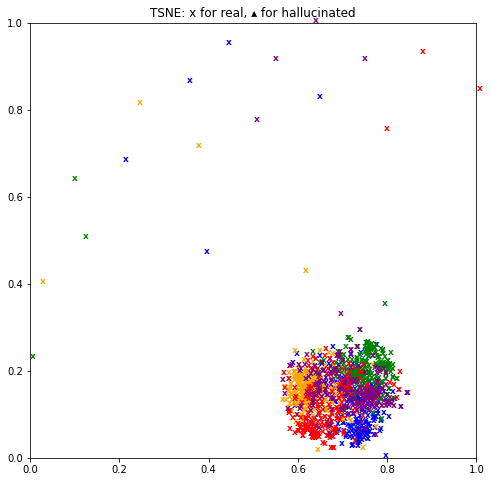

In [ ]:
plt.figure(figsize=(8, 8))
plt.title('TSNE: x for real, ▴ for hallucinated')
color_map = ['blue', 'orange', 'green', 'red', 'purple']

X_tsne = concate_embedded
class_list = []
domain_list = []

for i in range(N_way):
    class_num = 0
    while class_num < M+N_shot:
        class_list.append(i)
        class_num += 1

for i in range(N_way):
    class_num = 0
    while class_num < M+N_shot:
        if class_num < N_shot:
            domain_list.append('x')
            class_num += 1
        else:
            domain_list.append('▴')
            class_num += 1

x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # normalize
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], domain_list[i], color=color_map[class_list[i]], fontdict={'weight': 'bold', 'size': 9})
# plt.xticks([])
# plt.yticks([])

# plt.savefig(os.path.join(path, 'p3_tsne_feature.jpg'))
# print('save tsne image')
plt.show()

For Problem 2-3, you will do some experiments on different M-augmentation settings.

3. (10%) When meta-train and meta-test under the same 5-way 1-shot M-augmentation setting, please report and compare the accuracy with different number of hallucinated data. (M=10, 50, 100)

In [ ]:
# create N-way-K-shot train_loader
def create_train_loader(traincase_csv):
    train_loader = DataLoader(
            train_dataset, batch_size=train_N_way * (train_N_query + train_N_shot), num_workers=3, pin_memory=False, 
            worker_init_fn=worker_init_fn, sampler=GeneratorSampler(traincase_csv, 'train'))
    return train_loader

# set state
same_seeds(123) 

# sethyper parameters
train_N_way = 5
train_N_shot = 1 
train_N_query = 15
val_N_way = 5
val_N_shot = 1    
val_N_query = 15
num_episode = 100
M = 10 

# set data path
workspace_dir = "./hw4_data"
train_csv = os.path.join(workspace_dir, "train.csv")
train_data_dir = os.path.join(workspace_dir, "train")
val_csv = os.path.join(workspace_dir, "val.csv")
val_data_dir = os.path.join(workspace_dir, "val")
valcase_csv = os.path.join(workspace_dir, "val_testcase.csv")
gt_csv = os.path.join(workspace_dir, "val_testcase_gt.csv")

# set dataset
train_dataset = MiniDataset(train_csv, train_data_dir, 'train')
val_dataset = MiniDataset(val_csv, val_data_dir, 'test')
print('finish dataset')

val_loader = DataLoader(
        val_dataset, batch_size=val_N_way * (val_N_query + val_N_shot), num_workers=3, pin_memory=False, 
        worker_init_fn=worker_init_fn, sampler=GeneratorSampler(valcase_csv, 'val'))
print('finish data_loader')

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True
finish dataset
finish data_loader


In [ ]:
# set model
if torch.cuda.is_available():
    convnet = Convnet().cuda()
    hallucinator = Hallucinator().cuda()
else:
    convnet = Convnet()
    hallucinator = Hallucinator()

loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
convnet_optimizer = torch.optim.Adam(convnet.parameters(), lr=0.001) # optimizer 使用 Adam 
hallucinator_optimizer = torch.optim.Adam(hallucinator.parameters(), lr=0.001) # optimizer 使用 Adam
softmax = nn.Softmax(dim=1)

# set hyperparameters
num_epoch = 50
best_val_acc = 0.0

for epoch in range(num_epoch):
    training_epoch_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    traincase_csv = create_traincase(N=train_N_way, K=train_N_shot, N_query=train_N_query, num_episode=num_episode, train_csv=train_csv)
    train_loader = create_train_loader(traincase_csv)
    print("finish train_loader")

    convnet.train() 
    hallucinator.train()

    # each batch represent one episode (support data + query data)
    for i, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data = data.cuda()
        # split data into support and query data
        support_input = data[:train_N_way*train_N_shot, :, :, :] 
        query_input   = data[train_N_way*train_N_shot: , :, :, :]
        # create the relative label (0 ~ N_way-1) for query data
        label_encoder = {target[i*train_N_shot] : i for i in range(train_N_way)}
        if torch.cuda.is_available():
            query_label = torch.cuda.LongTensor([label_encoder[class_name] for class_name in target[train_N_way*train_N_shot:]])
        else:
            query_label = torch.LongTensor([label_encoder[class_name] for class_name in target[train_N_way*train_N_shot:]])

        convnet_optimizer.zero_grad() # 用 optimizer 將 convnet 參數的 gradient 歸零
        hallucinator_optimizer.zero_grad()

        support_encode = convnet(support_input).view(train_N_way, train_N_shot, -1) # extract the feature of support
        query_encode = convnet(query_input) # extract the feature of query
        noise = torch.randn(train_N_way, M, support_encode.shape[-1]).cuda() 
        for j in range(train_N_way): # generate hallucination data
            support_seed = support_encode[j][random.randint(0, train_N_shot-1)] # sample one feature in each class
            for m in range(M):
                noise[j][m] += support_seed # add seed to noise

        noise = hallucinator(noise.view(train_N_way*M, -1))
        support_proto = torch.cat((support_encode, noise.view(train_N_way, M, -1)), dim=1).mean(1)
        dists = euclidean_dist(query_encode, support_proto) 
        p = softmax(-dists)

        batch_loss = loss(p, query_label) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        convnet_optimizer.step() # 以 optimizer 用 gradient 更新參數值
        hallucinator_optimizer.step()

        train_acc += np.mean(np.argmax(p.cpu().data.numpy(), axis=1) == query_label.cpu().data.numpy())
        train_loss += batch_loss.item()
    
    convnet.eval() 
    hallucinator.eval()

    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            if torch.cuda.is_available():
                data = data.cuda()
            # split data into support and query data
            support_input = data[:val_N_way*val_N_shot, :, :, :] 
            query_input   = data[val_N_way*val_N_shot: , :, :, :]
            # create the relative label (0 ~ N_way-1) for query data
            label_encoder = {target[i*val_N_shot] : i for i in range(val_N_way)}
            if torch.cuda.is_available():
                query_label = torch.cuda.LongTensor([label_encoder[class_name] for class_name in target[val_N_way*val_N_shot:]])
            else:
                query_label = torch.LongTensor([label_encoder[class_name] for class_name in target[val_N_way*val_N_shot:]])

            support_encode = convnet(support_input).view(val_N_way, val_N_shot, -1) # extract the feature of support
            query_encode = convnet(query_input) # extract the feature of query
            noise = torch.randn(val_N_way, M, support_encode.shape[-1]).cuda()
            for j in range(val_N_way): # generate hallucination data
                support_seed = support_encode[j][random.randint(0, val_N_shot-1)]
                for m in range(M):
                    noise[j][m] += support_seed

            noise = hallucinator(noise.view(val_N_way*M, -1))
            support_proto = torch.cat((support_encode, noise.view(val_N_way, M, -1)), dim=1).mean(1)
            dists = euclidean_dist(query_encode, support_proto)
            p = softmax(-dists)

            batch_loss = loss(p, query_label) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
            val_acc += np.mean(np.argmax(p.cpu().data.numpy(), axis=1) == query_label.cpu().data.numpy())
            val_loss += batch_loss.item()

        if val_acc > best_val_acc :
            best_val_acc = val_acc
            torch.save(convnet.state_dict(), os.path.join(path, "p2_model", "p2_convnet_M10.pkl"))
            torch.save(hallucinator.state_dict(), os.path.join(path, "p2_model", "p2_hallucinator_M10.pkl"))
            print('save model')

    print('epoch : {}, training epoch time: {:.4f} (sec)'.format(epoch, time.time()-training_epoch_time))
    print('train acc: {:.4f}, train loss: {:.5f}, val acc: {:.4f}, val loss: {:.5f}, best val acc: {:.4f}'.format(
        train_acc/len(train_loader), train_loss/len(train_loader), val_acc/len(val_loader), val_loss/len(val_loader), best_val_acc/len(val_loader)
    ))

finish train_loader
save model
epoch : 0, training epoch time: 38.1665 (sec)
train acc: 0.2181, train loss: 1.68654, val acc: 0.1969, val loss: 1.70761, best val acc: 0.1969
finish train_loader
save model
epoch : 1, training epoch time: 37.4110 (sec)
train acc: 0.1983, train loss: 1.70648, val acc: 0.1994, val loss: 1.70528, best val acc: 0.1994
finish train_loader
save model
epoch : 2, training epoch time: 37.2208 (sec)
train acc: 0.2017, train loss: 1.70298, val acc: 0.2000, val loss: 1.70485, best val acc: 0.2000
finish train_loader
save model
epoch : 3, training epoch time: 36.8224 (sec)
train acc: 0.2068, train loss: 1.69799, val acc: 0.2010, val loss: 1.70375, best val acc: 0.2010
finish train_loader
epoch : 4, training epoch time: 36.6178 (sec)
train acc: 0.2063, train loss: 1.69840, val acc: 0.2010, val loss: 1.70336, best val acc: 0.2010
finish train_loader
epoch : 5, training epoch time: 36.5415 (sec)
train acc: 0.2013, train loss: 1.70331, val acc: 0.2006, val loss: 1.70416,

4. (5%) Discuss what you’ve observed and learned from implementing the data hallucination model.

**Hint    
In order to reduce the training time, you may use a model simpler than that in Problem 2-1 for
Problem 2-3. For example, you can train the model with less training epochs.**